### Imports & Definitions

In [1]:
import sys
sys.path.append("../../utils")
from definitions import *
from parsing_helpers import get_num_diplomas
from huggingface_helpers import get_tokenizer, get_model, get_num_tokens

In [2]:
years = [2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016]

### Read data

In [14]:
spbu_diplomas_dataset_path = ARTIFACTS_DIR_PATH.joinpath("parsing/diplomas/spbu/dataset.csv")
df = pd.read_csv(spbu_diplomas_dataset_path)
df.head()

,id,year,diploma,abstract
0,40165,2023,St. Petersburg State University\nGraduate Scho...,Данная работа исследует потенциал использовани...
1,41453,2023,Санкт-Петербургский государственный университе...,Абдуллаев Ш.У. тема диссертации: «Роль политик...
2,43790,2023,Санкт-Петербургский государственный университе...,Выпускная квалификационная работа посвящена из...
3,41165,2023,Санкт-Петербургский государственный университе...,В данной работе описывается реализация обобщен...
4,42349,2023,ПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ \nСАНКТ-ПЕТ...,В выпускной квалификационной работе раскрывает...


In [62]:
len(df)

14398

In [3]:
spbu_russian_diplomas_dataset_path = ARTIFACTS_DIR_PATH.joinpath("parsing/diplomas/spbu/russian_stupid_filter_dataset.csv")
russian_df = pd.read_csv(spbu_russian_diplomas_dataset_path)
russian_df.head()

,id,year,diploma,abstract
0,41453,2023,Санкт-Петербургский государственный университе...,Абдуллаев Ш.У. тема диссертации: «Роль политик...
1,43790,2023,Санкт-Петербургский государственный университе...,Выпускная квалификационная работа посвящена из...
2,41165,2023,Санкт-Петербургский государственный университе...,В данной работе описывается реализация обобщен...
3,42349,2023,ПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ \nСАНКТ-ПЕТ...,В выпускной квалификационной работе раскрывает...
4,40166,2023,Федеральное государственное бюджетное образова...,На сегодняшний день наблюдается высокий спрос ...


In [4]:
len(russian_df)

10924

### View some statistics

In [20]:
base_diplomas_spbu_dir_path = ARTIFACTS_DIR_PATH.joinpath("parsing/diplomas/spbu/")
new_rows = []
num_diplomas = dict()
len_ids = dict()
len_skipped_ids = dict()
for year in tqdm(years, desc="Years..."):
    ids_path = base_diplomas_spbu_dir_path.joinpath(f"{year}/ids.json")
    skipped_ids_path = base_diplomas_spbu_dir_path.joinpath(f"{year}/skipped_ids.jsons")
    with open(ids_path, "r") as f:
        ids = json.load(f)
    with open(skipped_ids_path, "r") as f:
        skipped_ids = [json.loads(x)["id"] for x in f.readlines()] 
    len_ids[year] = len(ids)
    len_skipped_ids[year] = len(skipped_ids)
    num_diplomas[year] = get_num_diplomas(year)

Years...: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


In [55]:
len_skipped_only_no_view_ids = dict()
for year in tqdm(years, desc="Years..."):
    ids_path = base_diplomas_spbu_dir_path.joinpath(f"{year}/ids.json")
    skipped_ids_path = base_diplomas_spbu_dir_path.joinpath(f"{year}/skipped_ids.jsons")
    skipped_only_no_veiw_ids = []
    with open(skipped_ids_path, "r") as f:
        for x in f.readlines():
            entry = json.loads(x)
            if entry["reason"] == "no work view":
                skipped_only_no_veiw_ids.append(entry["id"])
    len_skipped_only_no_view_ids[year] = len(skipped_only_no_veiw_ids)

Years...: 100%|██████████| 8/8 [00:00<00:00, 1912.15it/s]


In [64]:
df_rows = dict()
russian_df_rows = dict()
for year in tqdm(years, desc="Years..."):
    df_rows[year] = len(df[df["year"] == year])
    russian_df_rows[year] = len(russian_df[russian_df["year"] == year])
    not_skipped_only_no_view = len_ids[year] - len_skipped_only_no_view_ids[year]
    not_skipped_docs = len_ids[year] - len_skipped_ids[year]
    print(year, num_diplomas[year], len_ids[year], not_skipped_only_no_view, not_skipped_docs, df_rows[year], russian_df_rows[year])

Years...: 100%|██████████| 8/8 [00:00<00:00, 101.71it/s]

2023 2328 2128 1660 1654 1624 1387
2022 2139 2139 1783 1783 1770 1533
2021 1857 1857 1857 1853 1837 1535
2020 1185 1185 1185 1183 1177 983
2019 1035 1035 1035 1033 1019 836
2018 2730 2730 2697 2689 2648 2102
2017 3369 3369 3268 3248 2946 1655
2016 2494 1594 1416 1416 1377 893


Years...: 8it [00:00, 87154.37it/s]


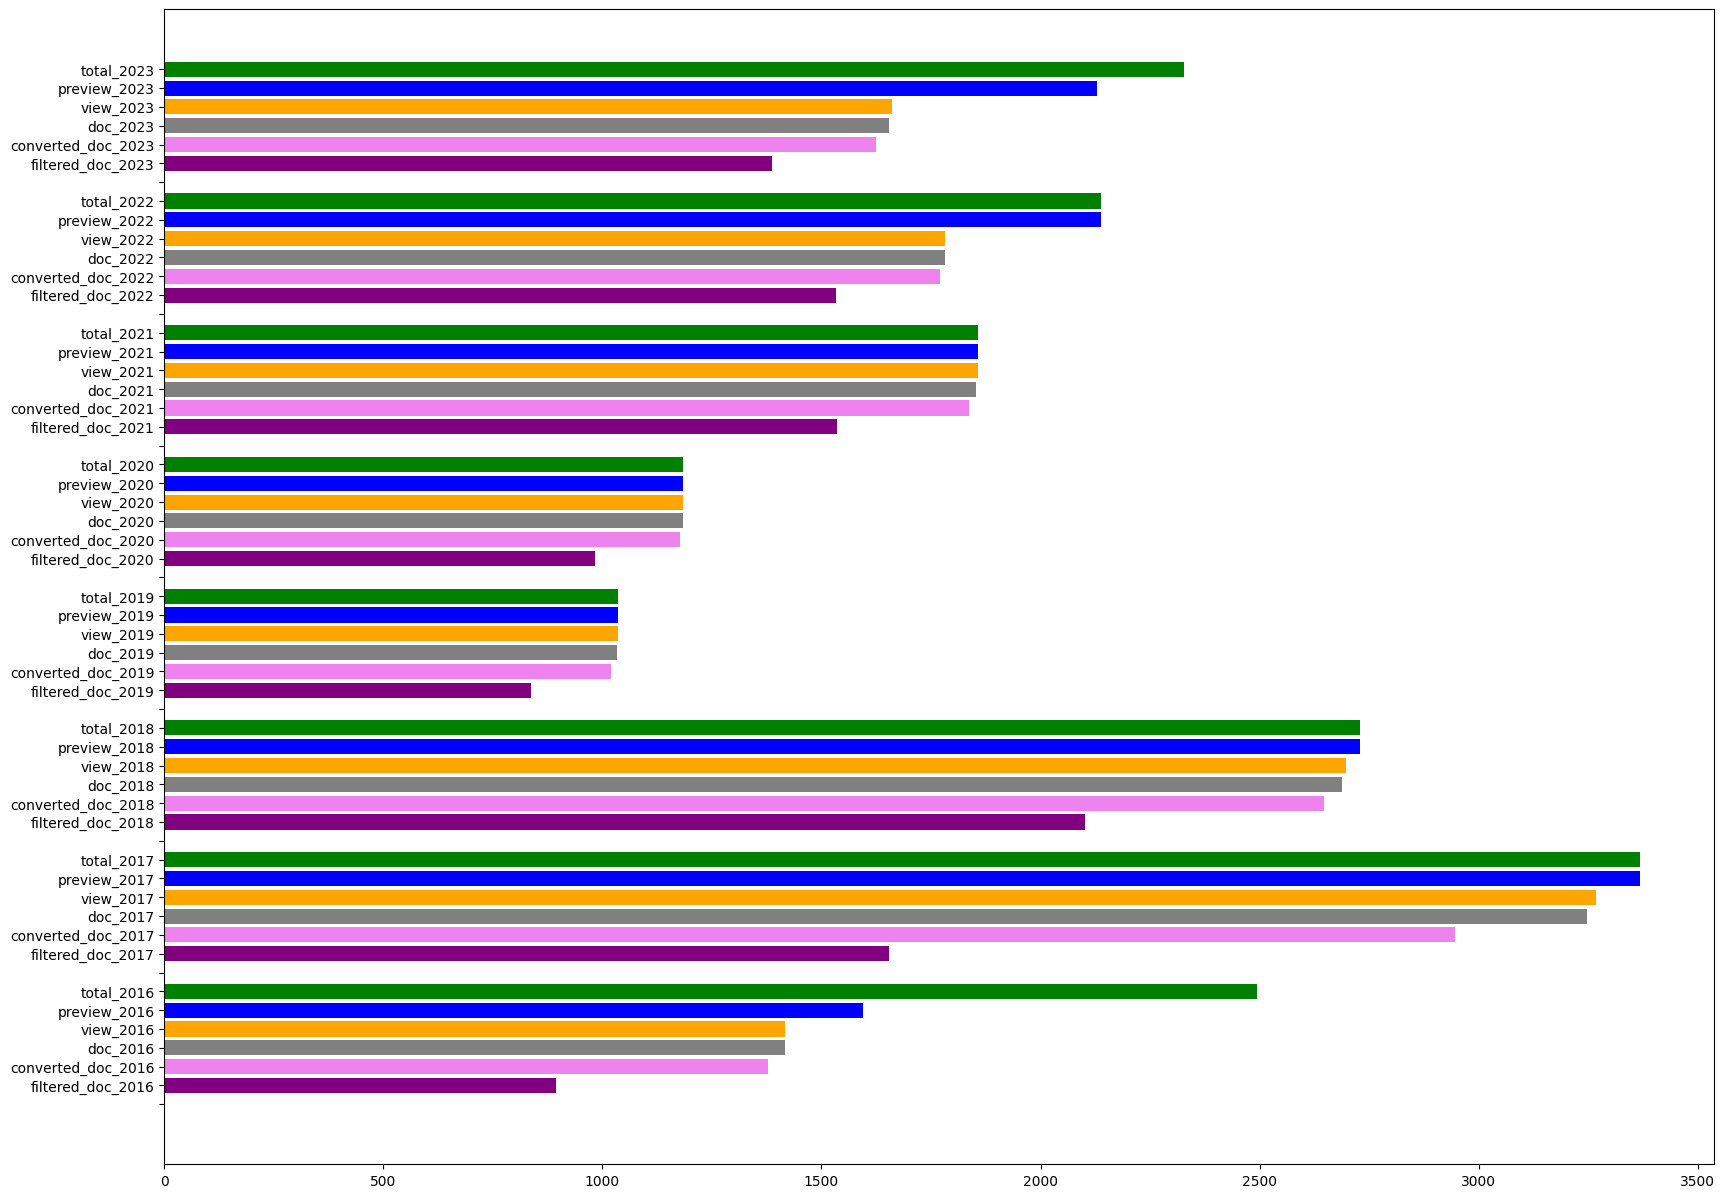

In [67]:
x_all = []
h_all = []
colors_all = []
for year in tqdm(reversed(years), desc="Years..."):
    h = np.array([num_diplomas[year], len_ids[year], len_ids[year] - len_skipped_only_no_view_ids[year], len_ids[year] - len_skipped_ids[year], df_rows[year], russian_df_rows[year], 0])
    x = [f"total_{year}", f"preview_{year}", f"view_{year}", f"doc_{year}", f"converted_doc_{year}", f"filtered_doc_{year}", " " * (year % 10)]
    colors = ["green", "blue", "orange", "gray", "violet", "purple", "red"]
    h_all.extend(reversed(h))
    x_all.extend(reversed(x))
    colors_all.extend(reversed(colors))
plt.figure(figsize=(20, 15))
plt.barh(x_all, h_all, height=0.8, color=colors_all)
plt.show()

In [54]:
len(df)

14398

### Apply tokenizers

In [4]:
model_to_repo = copy.deepcopy(HUGGINGFACE_MODEL_TO_REPO)
model_to_repo.pop(YALM_100B)
model_to_repo.pop(RUGPT3_XL)
model_to_repo

{'llama-2-7b': 'meta-llama/Llama-2-7b-hf',
 'falcon-7b': 'tiiuae/falcon-7b',
 'bloom': 'bigscience/bloom',
 'flan-t5-xxl': 'google/flan-t5-xxl',
 'fred-t5-1.7b': 'ai-forever/FRED-T5-1.7B',
 'phi': 'microsoft/phi-2',
 'dolly-v2-7b': 'databricks/dolly-v2-7b',
 'DeciLM-7b': 'Deci/DeciLM-7B',
 'saiga_mistral_7b_lora': 'IlyaGusev/saiga_mistral_7b_lora',
 'vicuna-7b': 'lmsys/vicuna-7b-v1.5',
 'vikhr-7b': 'Vikhrmodels/Vikhr-7b-0.1',
 'ru-longformer-large-4096': 'kazzand/ru-longformer-large-4096',
 'mistral-7b': 'mistralai/Mistral-7B-v0.1',
 'mixtral-8x7b': 'mistralai/Mixtral-8x7B-v0.1',
 'gemma-7b': 'google/gemma-7b',
 'ruT5-large': 'ai-forever/ruT5-large',
 'ruBert-large': 'ai-forever/ruBert-large',
 'ruRoberta-large': 'ai-forever/ruRoberta-large',
 'ruElectra-large': 'ai-forever/ruElectra-large',
 'mt5-xxl': 'google/mt5-xxl',
 'ru-e5-base': 'hivaze/ru-e5-base'}

In [5]:
debug=True
output_dir_path = ARTIFACTS_DIR_PATH.joinpath("tokens/full_russian_diplomas_stupid_filter/")
output_dir_path.mkdir(exist_ok=True, parents=True)
output_dir_path_abstract = ARTIFACTS_DIR_PATH.joinpath("tokens/full_russian_diplomas_stupid_filter_abstract/")
output_dir_path_abstract.mkdir(exist_ok=True, parents=True)
failed = []
for model, repo in tqdm(model_to_repo.items(), desc="Iterating through models"):
    try:
        tokenizer = get_tokenizer(model, repo)
        id_to_tokens = dict()
        id_to_tokens_abstract = dict()
        for _, row in tqdm(russian_df.iterrows(), total=len(russian_df), desc="rows..."):
            id_to_tokens[row["id"]] = get_num_tokens(tokenizer, row["diploma"])
            id_to_tokens_abstract[row["id"]] = get_num_tokens(tokenizer, row["abstract"])
        with open(output_dir_path.joinpath(f"{model}.json"), "w") as f:
            json.dump(id_to_tokens, f, indent=2, ensure_ascii=False)
        with open(output_dir_path_abstract.joinpath(f"{model}.json"), "w") as f:
            json.dump(id_to_tokens_abstract, f, indent=2, ensure_ascii=False)
    except Exception as e:
        if debug:
            print(f"failed {model} with exception {e}")
        failed.append(model)
if failed:
    print(f"Failed: {failed}.\nCheck that you logged in to hugginface and have permissions for those models.")
else:
    print("All ok")

Iterating through models:   0%|          | 0/21 [00:00<?, ?it/s]

/Users/nvdenisov2002/study/8-semester/diploma/.conda/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (171428 > 2048). Running this sequence through the model will result in indexing errors


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (146942 > 512). Running this sequence through the model will result in indexing errors
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (186741 > 2048). Running this sequence through the model will result in indexing errors
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (81428 > 32768). Running this sequence through the model will result in indexing errors


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (75472 > 4096). Running this sequence through the model will result in indexing errors


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (64166 > 4096). Running this sequence through the model will result in indexing errors


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (55125 > 512). Running this sequence through the model will result in indexing errors
/Users/nvdenisov2002/study/8-semester/diploma/.conda/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


rows...:   0%|          | 0/10924 [00:00<?, ?it/s]

In [ ]:
plot_tokens_distributions(output_dir_path, vlines_blue=[])

In [ ]:
plot_tokens_distributions(output_dir_path_abstract, vlines_blue=[], vlines_red=[])